In [16]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [17]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('DOGE-USD.csv')
df1=df.reset_index()['Close']

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 56ms/step - loss: 0.0190 - val_loss: 0.0017
Epoch 2/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0027 - val_loss: 1.4572e-04
Epoch 3/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0014 - val_loss: 7.3160e-05
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 6.7867e-05
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0010 - val_loss: 6.8725e-05
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0010 - val_loss: 8.0740e-05
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 9.5889e-04 - val_loss: 2.1842e-04
Epoch 8/100
16/16 [==============================] - 1s 38ms/step - loss: 9.7183e-04 - val_loss: 6.4338e-05
Epoch 9/100
16/16 [==============================] - 1s 36ms/step - loss: 8.9502e-04 - val_loss: 7.5875e-05
Epoch 10/100
16/16 [==============================] - 1s

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 9ms/step


In [26]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [27]:
y_train = y_train.reshape(y_train.shape[0],1)
ytest = ytest.reshape(ytest.shape[0],1)
yval = yval.reshape(yval.shape[0],1)

y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)
yval=scaler.inverse_transform(yval)

In [28]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE

# valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
# test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# print('Validation RMSE:', valid_rmse)
# print('Testing RMSE:', test_rmse)

import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

print('Train Score: %.2f RMSE' % (math.sqrt(mean_squared_error(y_train[:,0], train_predict[:,0]))))
print('Test Score: %.2f RMSE' % (math.sqrt(mean_squared_error(ytest[:,0], y_pred[:,0]))))
print('Val Score: %.2f RMSE' % (math.sqrt(mean_squared_error(yval[:,0], y_pred_val[:,0]))))
print('Train Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train[:,0], train_predict[:,0]))
print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(ytest[:,0], y_pred[:,0]))
print('Val Mean Absolute Percentage Error:', mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0]))
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(ytest[:,0], y_pred[:,0])))
print('Val Score: %.2f MAPE' % (mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0])))

r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared)
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared)

Validation RMSE: 0.003154707387607761
Testing RMSE: 0.005215613515979939
Train Score: 0.02 RMSE
Test Score: 0.01 RMSE
Val Score: 0.00 RMSE
Train Mean Absolute Percentage Error: 0.49185338376397575
Test Mean Absolute Percentage Error: 0.041010527380827354
Val Mean Absolute Percentage Error: 0.03179788797810242
Train Score: 0.49 MAPE
Test Score: 0.04 MAPE
Val Score: 0.03 MAPE
Test_R-squared:  0.9681258283948171
Val_R-squared:  0.8003786586381483


In [29]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96
i=0
while(i<30):

    if(len(temp_input)>96):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.10710532]
97
1 day input [0.10565394 0.10076108 0.10172853 0.09786751 0.10063375 0.10053276
 0.10233154 0.10088841 0.10494116 0.10247204 0.10381857 0.10345559
 0.10547392 0.10866899 0.11151572 0.11213629 0.11525818 0.12133511
 0.12555764 0.12381301 0.12016129 0.11920409 0.11511914 0.11726919
 0.12421111 0.12181371 0.12699344 0.12743399 0.12062087 0.12449066
 0.1241672  0.12526491 0.12623822 0.12981676 0.12704174 0.13850184
 0.13558047 0.13090861 0.13384755 0.13793835 0.13254201 0.12881564
 0.133246   0.12970406 0.11700574 0.11643493 0.11831128 0.11797758
 0.11799514 0.120012   0.12843803 0.12222206 0.12620602 0.12790527
 0.12503513 0.12685294 0.12276213 0.12293923 0.12112142 0.11615684
 0.11598999 0.11806247 0.11682132 0.11593584 0.11771413 0.11560067
 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815 0.10185733
 0.09432996 0.09410456 0.09521837 0.10166852 0.10465429 0.10720977
 0.10000732 0.10418155 0.10973011 0.10466747 0.10724782 0.10237984
 0.1102936  0.10605644 0.11105175 

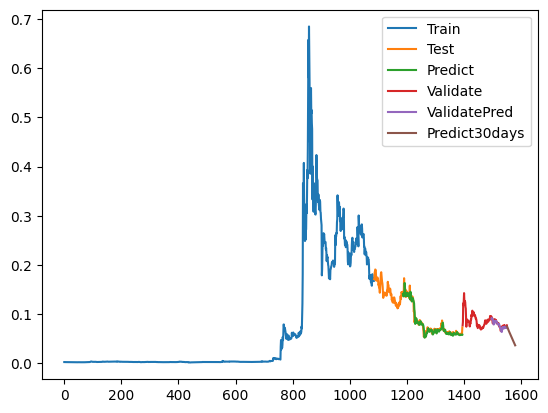

In [30]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()